In [ ]:
!pip install datasets
!pip install transformers[torch]
import torch
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TrainingArguments, BertForSequenceClassification, Trainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
emotion_corpus = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotion_corpus_train = emotion_corpus['train']
emotion_corpus_validation = emotion_corpus['validation']
emotion_corpus_test = emotion_corpus['test']
emotion_corpus_train.set_format(type="pandas")
emotion_corpus_validation.set_format(type="pandas")
emotion_corpus_test.set_format(type="pandas")
df_emotion_corpus_train = emotion_corpus_train[:]
df_emotion_corpus_validation = emotion_corpus_validation[:]
df_emotion_corpus_test = emotion_corpus_test[:]

print (df_emotion_corpus_validation)

                                                   text  label
0     im feeling quite sad and sorry for myself but ...      0
1     i feel like i am still looking at a blank canv...      0
2                        i feel like a faithful servant      2
3                     i am just feeling cranky and blue      3
4     i can have for a treat or if i am feeling festive      1
...                                                 ...    ...
1995  im having ssa examination tomorrow in the morn...      0
1996  i constantly worry about their fight against n...      1
1997  i feel its important to share this info for th...      1
1998  i truly feel that if you are passionate enough...      1
1999  i feel like i just wanna buy any cute make up ...      1

[2000 rows x 2 columns]


In [ ]:
df_emotion_corpus_validation["label_name"] = df_emotion_corpus_validation["label"].apply(lambda x: emotion_corpus_validation.features["label"].int2str(x))
print(df_emotion_corpus_validation[["text", "label_name"]])
print (df_emotion_corpus_validation["label_name"])
print (type(df_emotion_corpus_validation["label_name"]))
label_name = df_emotion_corpus_validation["label_name"].unique()
print (label_name)


                                                   text label_name
0     im feeling quite sad and sorry for myself but ...    sadness
1     i feel like i am still looking at a blank canv...    sadness
2                        i feel like a faithful servant       love
3                     i am just feeling cranky and blue      anger
4     i can have for a treat or if i am feeling festive        joy
...                                                 ...        ...
1995  im having ssa examination tomorrow in the morn...    sadness
1996  i constantly worry about their fight against n...        joy
1997  i feel its important to share this info for th...        joy
1998  i truly feel that if you are passionate enough...        joy
1999  i feel like i just wanna buy any cute make up ...        joy

[2000 rows x 2 columns]
0       sadness
1       sadness
2          love
3         anger
4           joy
         ...   
1995    sadness
1996        joy
1997        joy
1998        joy
1999       

In [ ]:
#https://huggingface.co/bert-base-uncased
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Training using pretrained model weights
model_ckpt = "bert-base-uncased"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=6))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="macro")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

In [ ]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, texts, labels=None):
       self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
       self.labels = labels
   def __getitem__(self, idx):
       item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
       if self.labels:
           item["labels"] = torch.tensor(self.labels[idx])
       return item
   def __len__(self):
       return len(self.encodings["input_ids"])


In [ ]:
train_dataset = Dataset(emotion_corpus["train"]["text"].tolist(), emotion_corpus["train"]["label"].tolist())
validation_dataset = Dataset(emotion_corpus["validation"]["text"].tolist(), emotion_corpus["validation"]["label"].tolist())
test_dataset = Dataset(emotion_corpus["test"]["text"].tolist(), emotion_corpus["test"]["label"].tolist())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print (train_dataset.encodings["input_ids"][0])
tokens = tokenizer.convert_ids_to_tokens(train_dataset.encodings["input_ids"][0])
print (tokens)
print(tokenizer.convert_tokens_to_string(tokens))
print (train_dataset.labels[0])


[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[CLS]', 'i', 'didn', '##t', 'feel', 'humiliated', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [ ]:
training_args = TrainingArguments(
  output_dir="output",
  evaluation_strategy="steps",
  eval_steps=100,
  num_train_epochs=2,
  seed=0,
  load_best_model_at_end=True,
  fp16=True)

In [ ]:
trainer = Trainer(
 model=model,
 args = training_args,
 compute_metrics=compute_metrics,
 train_dataset=train_dataset,
 eval_dataset=validation_dataset,
 tokenizer=tokenizer
 )
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,0.912242,0.702000,0.519106
200,No log,0.582800,0.809000,0.694033
300,No log,0.388829,0.886500,0.847564
400,No log,0.373854,0.901000,0.877743
500,0.706300,0.433822,0.881000,0.839444
600,0.706300,0.360943,0.914500,0.892847
700,0.706300,0.343312,0.920500,0.898127
800,0.706300,0.289919,0.913000,0.866041
900,0.706300,0.370854,0.912500,0.886946
1000,0.358500,0.286045,0.925000,0.902039


TrainOutput(global_step=4000, training_loss=0.2592992095947266, metrics={'train_runtime': 642.4561, 'train_samples_per_second': 49.809, 'train_steps_per_second': 6.226, 'total_flos': 1430717745024000.0, 'train_loss': 0.2592992095947266, 'epoch': 2.0})

In [ ]:
predictions = trainer.predict(test_dataset)
print (predictions.metrics)

{'test_loss': 0.16771534085273743, 'test_accuracy': 0.9265, 'test_f1': 0.8771241241852173, 'test_runtime': 5.4771, 'test_samples_per_second': 365.154, 'test_steps_per_second': 45.644}


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

[[ 7.9492188  -1.7519531  -2.28125    -2.0917969  -1.0087891  -1.1201172 ]
 [ 8.125      -1.9003906  -2.5058594  -1.640625   -0.95996094 -1.2041016 ]
 [ 8.0859375  -1.7929688  -2.3691406  -1.5664062  -1.1699219  -1.3447266 ]
 ...
 [-2.0273438   7.8984375  -1.0878906  -1.2958984  -2.2265625  -1.5888672 ]
 [-1.9462891   7.7617188  -1.1650391  -1.1464844  -1.8144531  -1.8867188 ]
 [-1.9335938  -1.3710938  -2.4824219  -2.4804688   3.0292969   3.5019531 ]]
[0 0 0 ... 1 1 5]
[0, 0, 0, 1, 0, 4, 3, 1, 1, 3, 4, 0, 4, 1, 2, 0, 1, 0, 3, 1, 0, 1, 1, 0, 0, 4, 3, 0, 4, 3, 4, 3, 0, 3, 0, 1, 1, 0, 1, 1, 3, 0, 1, 0, 1, 3, 1, 1, 4, 4, 0, 4, 1, 0, 1, 0, 0, 1, 0, 3, 0, 0, 1, 1, 0, 5, 0, 3, 4, 5, 1, 2, 5, 1, 2, 3, 1, 0, 1, 2, 1, 3, 0, 1, 0, 0, 1, 1, 1, 0, 1, 4, 3, 4, 3, 3, 2, 0, 3, 0, 0, 0, 0, 4, 3, 3, 1, 1, 4, 0, 1, 2, 4, 1, 0, 1, 1, 4, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 0, 1, 2, 0, 3, 3, 1, 4, 3, 0, 1, 1, 0, 4, 1, 1, 0, 1, 4, 4, 2, 0, 2, 5, 0, 1, 0, 1, 1, 3, 0, 3, 3, 1, 4, 4, 1, 2, 2, 2, 0, 2, 3, 1, 1, 0, 

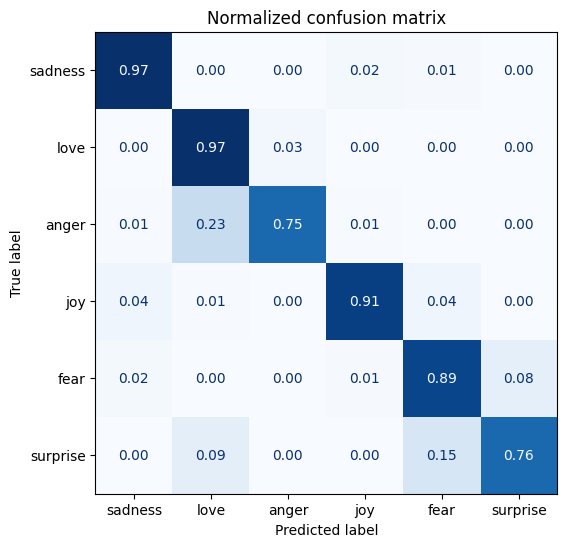

In [ ]:
import numpy as np
print (predictions.predictions)
y_preds = np.argmax(predictions.predictions, axis=-1)
print (y_preds)
y_test = emotion_corpus["test"]["label"].tolist()
print (y_test)
plot_confusion_matrix(y_preds, y_test, label_name)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds, target_names=label_name))


              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
        love       0.93      0.97      0.95       695
       anger       0.87      0.75      0.81       159
         joy       0.95      0.91      0.93       275
        fear       0.88      0.89      0.88       224
    surprise       0.69      0.76      0.72        66

    accuracy                           0.93      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.93      0.93      0.93      2000

